## Bitcoin price forecasting

In this notebook we use different forecasting models in order to predict the price of Bitcoin.

In [63]:
#https://builtin.com/data-science/time-series-forecasting-python

import yfinance as yf
from pandas_datareader import data as pdr

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime

from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot
from random import randint

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)


In [64]:
#import pandas_datareader.data as web
#import datetime

In [65]:
#import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [66]:
yf.pdr_override() 

start_date = '2018-01-01'
end_date = '2020-12-2'
btc = pdr.get_data_yahoo(['BTC-USD'], start_date, end_date)
close_price = stock_data['Close']
highs = stock_data['High']

[*********************100%***********************]  1 of 1 completed


In [67]:
print(btc.head())

                    Open          High           Low         Close  \
Date                                                                 
2018-01-01  14112.200195  14112.200195  13154.700195  13657.200195   
2018-01-02  13625.000000  15444.599609  13163.599609  14982.099609   
2018-01-03  14978.200195  15572.799805  14844.500000  15201.000000   
2018-01-04  15270.700195  15739.700195  14522.200195  15599.200195   
2018-01-05  15477.200195  17705.199219  15202.799805  17429.500000   

               Adj Close       Volume  
Date                                   
2018-01-01  13657.200195  10291200000  
2018-01-02  14982.099609  16846600192  
2018-01-03  15201.000000  16871900160  
2018-01-04  15599.200195  21783199744  
2018-01-05  17429.500000  23840899072  


In [68]:
# Save historical prices into a file
btc.to_csv("btc.csv")

In [77]:
btc = pd.read_csv("btc.csv")
print(btc.head())

         Date          Open          High           Low         Close  \
0  2018-01-01  14112.200195  14112.200195  13154.700195  13657.200195   
1  2018-01-02  13625.000000  15444.599609  13163.599609  14982.099609   
2  2018-01-03  14978.200195  15572.799805  14844.500000  15201.000000   
3  2018-01-04  15270.700195  15739.700195  14522.200195  15599.200195   
4  2018-01-05  15477.200195  17705.199219  15202.799805  17429.500000   

      Adj Close       Volume  
0  13657.200195  10291200000  
1  14982.099609  16846600192  
2  15201.000000  16871900160  
3  15599.200195  21783199744  
4  17429.500000  23840899072  


In [78]:
btc.index = pd.to_datetime(btc['Date'], format='%Y-%m-%d')

In [79]:
# Remove the 'Date' column
del btc['Date']

In [80]:
btc.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,10291200000
2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192
2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160
2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744
2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000,23840899072
2018-01-06,17462.099609,17712.400391,16764.599609,17527.000000,17527.000000,18314600448
2018-01-07,17527.300781,17579.599609,16087.700195,16477.599609,16477.599609,15866000384
2018-01-08,16476.199219,16537.900391,14208.200195,15170.099609,15170.099609,18413899776
2018-01-09,15123.700195,15497.500000,14424.000000,14595.400391,14595.400391,16659999744


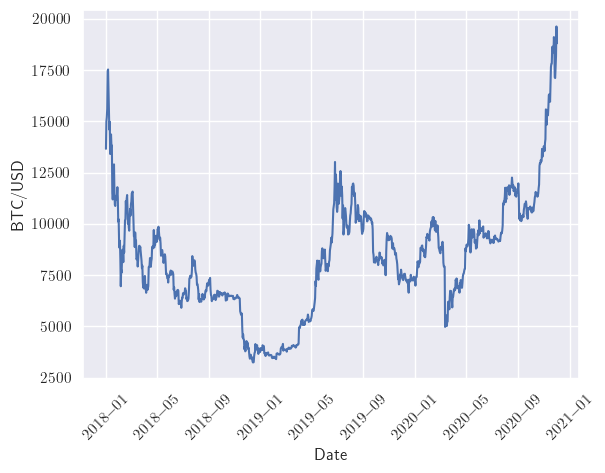

In [81]:
sns.set()
plt.ylabel('BTC/USD')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(btc.index, btc['Close'], )

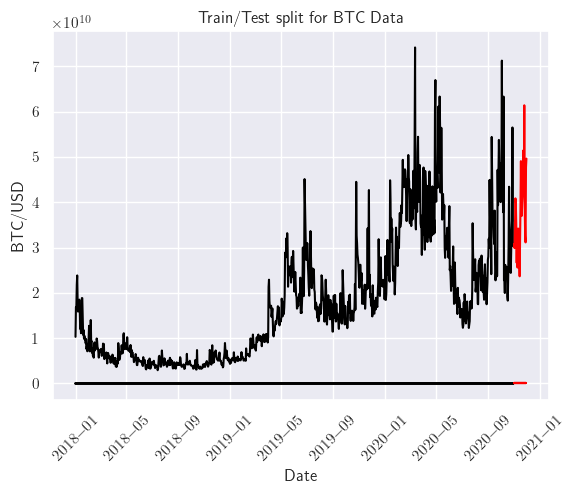

In [82]:
train = btc[btc.index < pd.to_datetime("2020-11-01", format='%Y-%m-%d')]
test = btc[btc.index > pd.to_datetime("2020-11-01", format='%Y-%m-%d')]

plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('BTC/USD')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for BTC Data")
plt.show()

In [83]:
y = train['Close']


• **ARMA** $(p,q)$: The notation ARMA $(p, q)$ refers to the model with p autoregressive terms and q moving-average terms. This model contains the AR $(p)$ and MA $(q)$ models
$$ X_t = \varepsilon_t +  \sum_{i=1}^p b_i X_{t-i} +  \sum_{i=1}^{q} c_i \varepsilon_{t-i}  $$
where $b_i,c_i$ are the paremters in the model. Finding appropriate values of $p$ and $q$ in the ARMA $(p,q)$ model can be facilitated by plotting the partial autocorrelation functions for an estimate of $p$, and likewise using the autocorrelation functions for an estimate of $q$. Extended autocorrelation functions (EACF) can be used to simultaneously determine $p$ and $q$. ARMA is limited in that it fails for non-stationary time series and does not capture seasonality.


In [84]:
ARMAmodel = SARIMAX(y, order = (1, 0, 1))
ARMAmodel = ARMAmodel.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.25852D+00    |proj g|=  7.50049D-03

At iterate    5    f=  7.25849D+00    |proj g|=  2.46666D-03

At iterate   10    f=  7.25818D+00    |proj g|=  1.56769D-02

At iterate   15    f=  7.25789D+00    |proj g|=  2.90419D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     18      1     0     0   2.904D-05   7.258D+00
  F =   7.2578878305770411     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FA

/home/alexis/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alexis/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [90]:
y_pred = ARMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_arma = y_pred_df["Predictions"] 

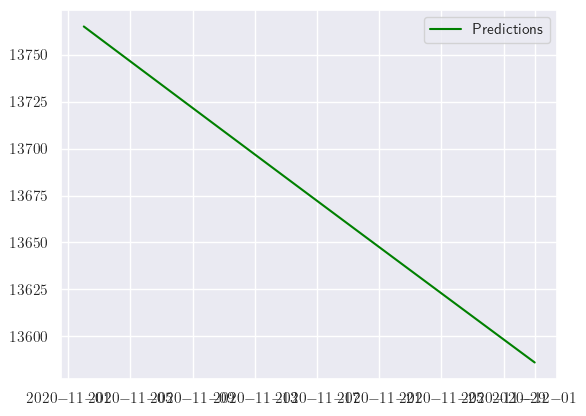

In [91]:
plt.plot(y_pred_arma, color='green', label = 'Predictions')
plt.legend()

In [87]:
arma_rmse = np.sqrt(mean_squared_error(test["Close"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  3562.135691276017


/home/alexis/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alexis/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alexis/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alexis/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/alexis/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimiza

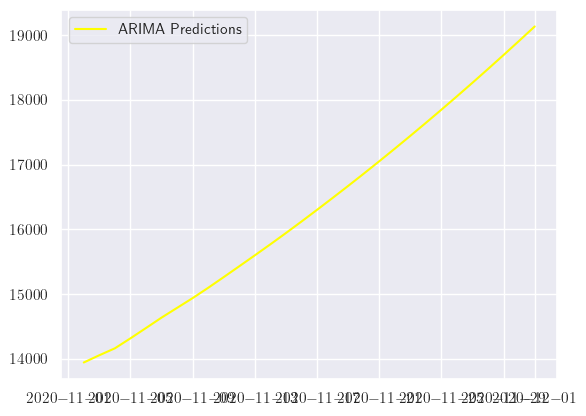

In [92]:
ARIMAmodel = ARIMA(y, order = (5, 4, 2))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_arima = y_pred_df["Predictions"] 
plt.plot(y_pred_arima, color='Yellow', label = 'ARIMA Predictions')
plt.legend()


In [93]:
arma_rmse = np.sqrt(mean_squared_error(test["Close"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  907.7036191189471


/home/alexis/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alexis/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alexis/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/alexis/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.54717D+00    |proj g|=  2.91938D+00

At iterate    5    f=  7.82229D+00    |proj g|=  8.80276D-02

At iterate   10    f=  7.80017D+00    |proj g|=  2.62975D-02

At iterate   15    f=  7.78139D+00    |proj g|=  1.09080D-02

At iterate   20    f=  7.77027D+00    |proj g|=  3.23180D-02

At iterate   25    f=  7.75005D+00    |proj g|=  6.96695D-03

At iterate   30    f=  7.74393D+00    |proj g|=  2.67586D-03

At iterate   35    f=  7.74284D+00    |proj g|=  1.00934D-03

At iterate   40    f=  7.74191D+00    |proj g|=  9.15002D-03

At iterate   45    f=  7.72707D+00    |proj g|=  3.91029D-02


/home/alexis/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  7.71946D+00    |proj g|=  3.08053D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     61      1     0     0   3.081D-03   7.719D+00
  F =   7.7194551869729189     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


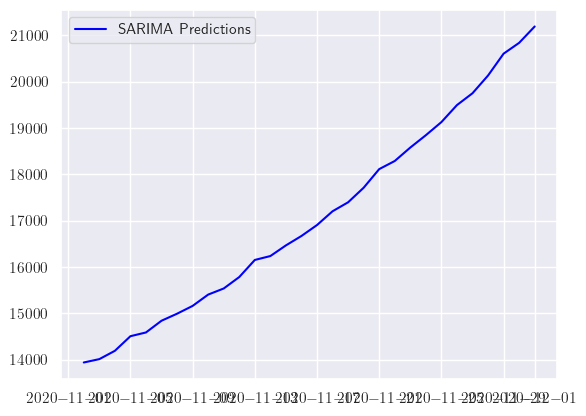

In [100]:
SARIMAXmodel = SARIMAX(y, order = (5, 4, 2), seasonal_order=(2,2,2,8))
SARIMAXmodel = SARIMAXmodel.fit()

y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_sarima = y_pred_df["Predictions"] 
plt.plot(y_pred_sarima, color='Blue', label = 'SARIMA Predictions')
plt.legend()

In [101]:
arma_rmse = np.sqrt(mean_squared_error(test["Close"].values, y_pred_df["Predictions"]))
print("SARIMA RMSE: ",arma_rmse)

SARIMA RMSE:  1111.379604428871


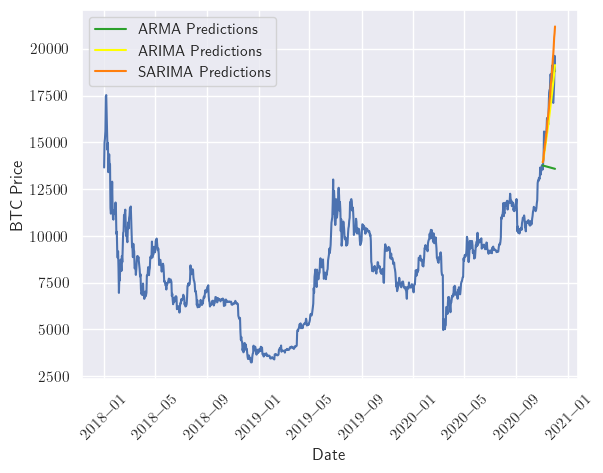

In [102]:
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(btc.index, btc['Close'], )
plt.plot(y_pred_arma, color='tab:green', label = 'ARMA Predictions')
plt.plot(y_pred_arima, color='yellow', label = 'ARIMA Predictions')
plt.plot(y_pred_sarima, color='tab:orange', label = 'SARIMA Predictions')
plt.legend()